In [1]:
import sys
sys.path.append('../')
from utils.evaluation import *
from utils.net_classification import *
from GA.geneticAlgorithm import TwoLevelGA
from GA.random_search import RandomSearcher
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data
def get_data(dataset, parent_dir, runs, loader_object, divisions=5, divs_class_0=1,
             fitness_lim=0.1, one_level=False):
    
    runs = os.listdir(parent_dir) if runs is None else runs
    sorted_h, sorted_ph = get_sorted_individuals_from_evolutions(dataset, parent_dir, runs, loader_object)
    table_h, table_ph = get_sorted_tables(sorted_h=sorted_h, sorted_ph=sorted_ph)
    table = table_h if one_level else table_ph
    sorted_p = sorted_h if one_level else sorted_ph
    divisions, percentiles_dict = get_divisions(sorted_p, divisions=divisions, fitness_lim=fitness_lim)
    Xr, Yc = get_Xr_Y(table, divisions, fitness_lim=fitness_lim, regression=False, binary=True,
                     divisions_class_0=divs_class_0)
    return Xr, Yc, percentiles_dict, sorted_p

def get_divisions(sorted_, divisions, fitness_lim=0.1):
    div_mode = 'fit'
    h = [s for s in sorted_ if s[1] < fitness_lim]
    percentiles_dict, divisions = make_percentiles(h, divisions, div_mode)
    print(divisions)
    return divisions, percentiles_dict
    
divisions = 5
divs_class_0 = 4
Xr, Yc, pdict, _ = get_data('MRDBI', '../../evolved_data/population_opt', loader_object=TwoLevelGA,
                  runs=None, one_level=False, divisions=divisions, divs_class_0=divs_class_0)
print(np.sum(Yc==0), np.sum(Yc==1), len(Yc))

Using TensorFlow backend.


[0.066745  0.0733488 0.0799526 0.0865564 0.0931602 0.099764 ]
405 15 420


In [ ]:
dataset_names = ['test_validation3', 'validation', '1level/54_epochs', 
                 '1level_20gen/54_epochs', 'population_opt', 'random_search/54_epochs']

datasets = {}
for dataset in dataset_names:
    one_level = '54' in dataset
    loader_object = RandomSearcher if 'random' in dataset else TwoLevelGA
    Xr, Yc, _, _ = get_data('MRDBI', '../../evolved_data/%s' % dataset, loader_object=loader_object,
                      runs=None, one_level=one_level, divisions=divisions, divs_class_0=divs_class_0)
    print(dataset,":", Xr.shape)
    print(np.sum(Yc==0), np.sum(Yc==1), len(Yc))
    datasets[dataset.split('/')[0]] = (Xr, Yc)
    print("\n\n")

In [4]:
def evaluate(X_, Y_, estimator, selector):
    w0 = np.sum(Y_ == 0)
    w1 = np.sum(Y_ == 1)
    w = w0 + w1
    # x_train, y_train = shuffle(X_, Y_)
    # x_train = selector.fit_transform(x_train, y_train)

    scores = []
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=100)
    X_ = selector.fit_transform(X_, Y_)
    for train_index, test_index in rskf.split(X_, Y_):
        x_train, x_test = X_[train_index], X_[test_index]
        y_train, y_test = Y_[train_index], Y_[test_index]
        try:
            weights = [w / w0 if y == 0 else w / w1 for y in y_train]
            estimator.fit(x_train, y_train, weights)
        except TypeError:
            estimator.fit(x_train, y_train)
        weights = [w / w0 if y == 0 else w / w1 for y in y_test]
        score = estimator.score(x_test, y_test, weights)
        scores.append(score)
    weights = [w / w0 if y == 0 else w / w1 for y in Y_]
    score = estimator.score(X_, Y_, weights)
    return estimator, selector, (np.mean(scores), score)

def train_estimator(X_, Y_, estimator, selector, k):
    w0 = np.sum(Y_ == 0)
    w1 = np.sum(Y_ == 1)
    w = w0 + w1
    _ = selector.func_(k=None, X_=X_, svc=estimator)
    selector = selector.func_(k=k, X_=X_, svc=estimator)
    X_ = selector.fit_transform(X_, Y_)
    weights = [w / w0 if y == 0 else w / w1 for y in Y_]
    try:
        estimator.fit(X_, Y_, weights)
    except TypeError:
        estimator.fit(X_, Y_)
    score = estimator.score(X_, Y_, weights)
    return estimator, selector, score, (w0, w1)

def evaluate_on_dataset(X_, Y_, estimator, selector, ws):
    w0, w1 = ws
    w = w1 + w0
    X_ = selector.get_x_from_score(X_)
    y_pred = estimator.predict(X_)
    score = balanced_accuracy_score(Y_, y_pred)
    #score = estimator.score(X_, Y_, weights)
    return score

def get_features_from_model(model):
    b = -1
    features_dict = {b: {}}
    for value, function in get_util_functions().items():
        features_dict[b][value] = function(str(model))
    c = pd.DataFrame(features_dict, index=self.table.columns).T
    x = get_Xr(c)
    return x



Getting best number of features
features :[===========================================]


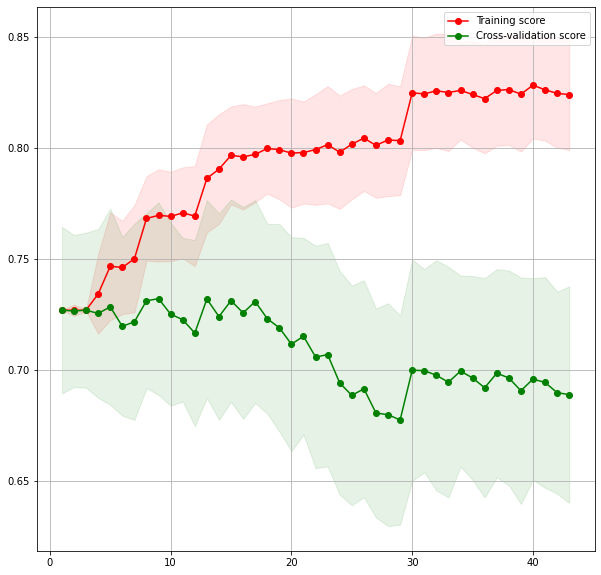

test_validation3 number of features 9
Training model with all data
Testing model with each dataset
Dataset: [======]
Getting best number of features
features :[===========================================]


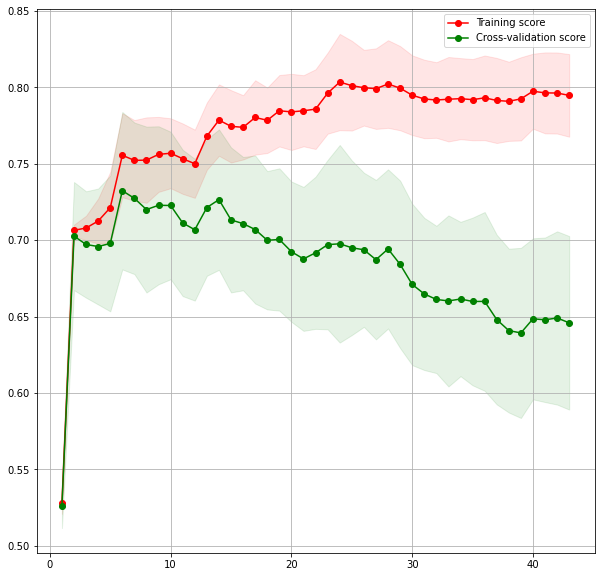

validation number of features 6
Training model with all data
Testing model with each dataset
Dataset: [======]
Getting best number of features
features :[===========================================]


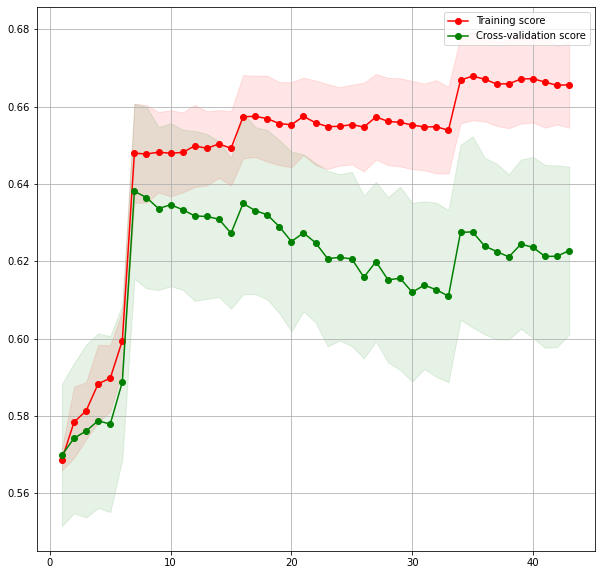

1level number of features 7
Training model with all data
Testing model with each dataset
Dataset: [======]
Getting best number of features
features :[===========================================]


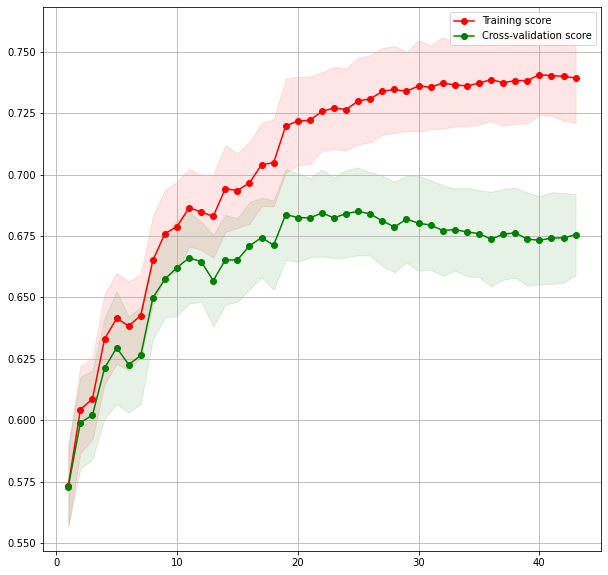

1level_20gen number of features 25
Training model with all data
Testing model with each dataset
Dataset: [======]
Getting best number of features
features :[===========================================]


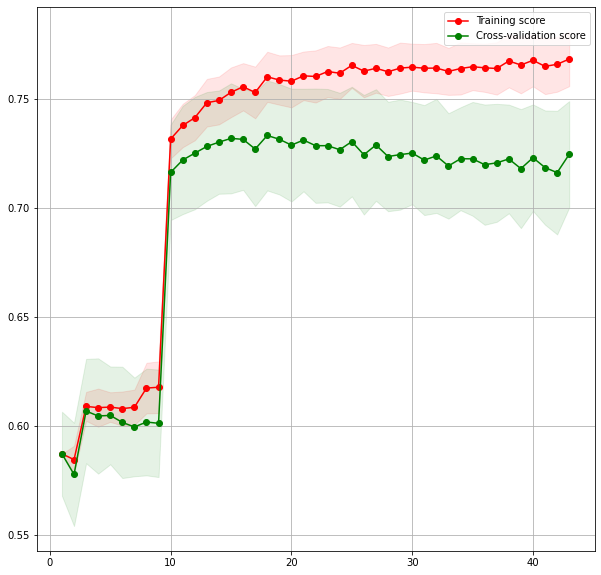

population_opt number of features 18
Training model with all data
Testing model with each dataset
Dataset: [======]
Getting best number of features
features :[===========================================]


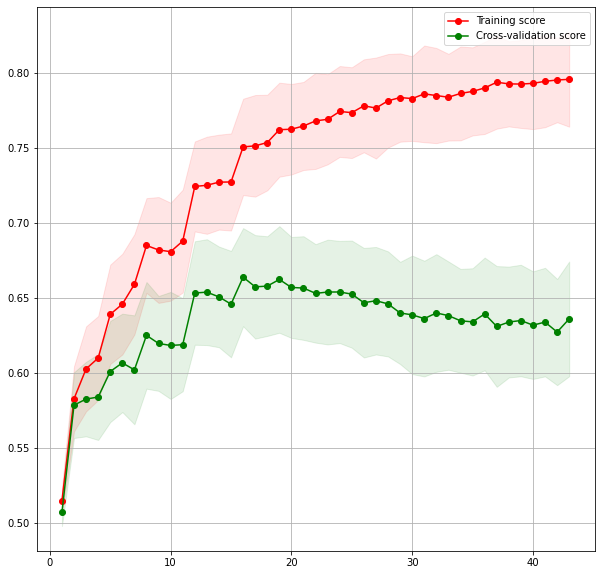

random_search number of features 16
Training model with all data
Testing model with each dataset
Dataset: [======]


In [9]:
results = np.zeros((len(datasets.keys()), len(datasets.keys())))

for k_train, dataset_train in enumerate(datasets.keys()):
    # load train data
    Xr, Yc = datasets[dataset_train]
    
    # get best number of features
    print("Getting best number of features")
    estimator = SVC(kernel="linear", gamma='auto', C=10)
    test_scores_mean, test_scores_std, n_features = evaluate_range_values(Xr, Yc, estimator, get_RFE,
                                                                          reps=100, plot=True)
    n_features_ = np.argmax(test_scores_mean) + 1
    print(dataset_train,"number of features", n_features_)
    
    # train estimator with all data
    print("Training model with all data")
    estimator = SVC(kernel="linear", gamma='auto', C=10)
    selector = SelectorRFE()
    estimator, selector, score, ws = train_estimator(Xr, Yc, estimator, selector, k=n_features_)
    
    # test estimator on each dataset
    print("Testing model with each dataset")
    print("Dataset: [", end='')
    for k_test, dataset_test in enumerate(datasets.keys()):
        X_test, Y_test = datasets[dataset_test]
        test_score = evaluate_on_dataset(X_test, Y_test, estimator, selector, ws)
        results[k_train, k_test] = test_score
        print("=", end='')
    print("]")


In [10]:
print(datasets.keys())
print(results)

dict_keys(['test_validation3', 'validation', '1level', '1level_20gen', 'population_opt', 'random_search'])
[[0.7694617  0.62278832 0.4956968  0.55275779 0.59642331 0.53459966]
 [0.63973566 0.77754609 0.59514469 0.5970266  0.56753325 0.61572076]
 [0.65435474 0.52563807 0.65263005 0.64143741 0.59469804 0.61910845]
 [0.64748201 0.57777778 0.62928349 0.71361502 0.6047619  0.55395683]
 [0.71862688 0.56284172 0.52815648 0.6148558  0.77860042 0.58393285]
 [0.5971223  0.57777778 0.62149533 0.60328638 0.54761905 0.72661871]]


In [42]:
class_info = {'results':results.tolist(), 'datasets':list(datasets.keys()), 'n_features':[10, 11, 1, 17, 18, 18]}
class_info = {'results':results.tolist(), 'datasets':list(datasets.keys()), 'n_features':[9, 6, 7, 25, 18, 16]}

import json
save_json = '../../resources/2divisions/2_divisions_1_div_class0.json'
save_json = '../../resources/5divisions/5_divisions_1_div_class0.json'

#with open(save_json, 'w') as f:
#    json.dump(class_info, f, indent=4)

with open(save_json) as json_file:
    class_info_ = json.load(json_file)

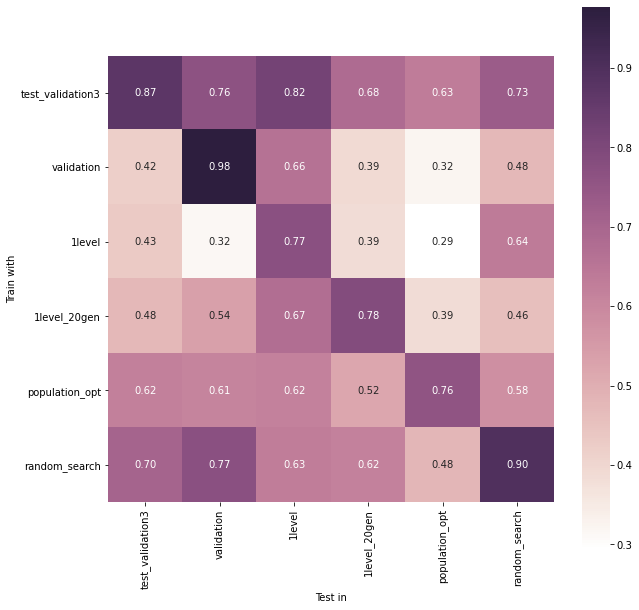

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


def plot_cm(cm, labels, figsize=(10,10)):
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            annot[i, j] = '%.2f' % c
            #p = cm_perc[i, j]

    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Train with'
    cm.columns.name = 'Test in'
    fig, ax = plt.subplots(figsize=figsize)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(cm, cmap=cmap, annot=annot, fmt='', ax=ax, square=True)
    
results = np.array(class_info_['results'])
results = results.copy()
labels = class_info_['datasets']

plot_cm(results, labels=labels)


In [35]:
labels = list(datasets.keys())
for i in range(len(labels)):
    lab = labels[i]
    row = results[i, :]
    row[i] = 0
    print("Generalization in (%s): %0.2f" % (lab, np.sum(row)/(len(labels)-1)))

Generalization in (test_validation3): 0.56
Generalization in (validation): 0.60
Generalization in (1level): 0.61
Generalization in (1level_20gen): 0.60
Generalization in (population_opt): 0.60
Generalization in (random_search): 0.59


In [ ]:
k = 8

Xr, Yc = datasets['test_validation3']
#Xr, Yc = datasets['validation']



features = []
test_accuracies = []
accuracies = []
for k in range(1, Xr.shape[1]):
    estimator = SVC(kernel="linear", gamma='auto', C=10)
    selector = SelectorRFE()
    _ = selector.func_(k=None, X_=Xr, svc=estimator)
    selector = selector.func_(k=k, X_=Xr, svc=estimator)
    estimator, selector, (all_score, score) = evaluate(Xr, Yc, estimator, selector)
    features.append(k)
    accuracies.append(all_score)
    test_accuracies.append(score)

In [ ]:
plt.plot(features, accuracies, label='all data')
plt.plot(features, test_accuracies, label='test data')
plt.legend()
plt.show()

In [ ]:
final_dict = evaluate_estimators(Xr, Yc, estimators_dict, get_RFE, reps=10, title='')

In [ ]:
plot_selectors(final_dict['SVC_linear'])

In [ ]:
estimator = SVC(kernel="linear", gamma='auto', C=10)
test_scores_mean, test_scores_std, n_features = evaluate_range_values(Xr, Yc, estimator, get_RFE,
                                                                      reps=100, plot=True)
n_features_ = np.argmax(test_scores_mean) + 1
print(n_features, n_features_)

In [ ]:
selectors_dict = get_selectors_dict()
estimators_dict = get_estimators_dict()

In [ ]:

final_dict = {}
selectors_dict.keys()
for s in selectors_dict.keys():
    final_dict[s] = evaluate_estimators(Xr, Yc, estimators_dict, selectors_dict[s], reps=10, title='')

### Evaluating net at the ends f the dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
def evaluate_model_on_percentiles(model, pdict):
    correct = 0
    results_dict = {}
    for p, models in pdict.items():
        results_dict[p] = {'goods':0, 'bads':0}
        goods = 0
        data_size = len(models)
        for model_i in models:
            goods += model.is_model_ok(model_i[0])
        results_dict[p]['goods'] = goods * 100 / data_size
        results_dict[p]['bads'] = 100 - results_dict[p]['goods']
    return results_dict

def evaluate_proba(model, sorted_p, title='', fit_lim=0.3):
    score = [model.get_model_prob(model_arch[0]) for model_arch in sorted_p if model_arch[1]<fit_lim]
    fit  =  [model_arch[1] for model_arch in sorted_p if model_arch[1]<fit_lim]
    plt.plot(fit, score, '.')
    plt.ylabel('Score')
    plt.xlabel('Fitness')
    plt.title(title)
    plt.show()

def evaluate_model_on_dataset(model, sorted_p, title='', plot_seq=False):
    plt.figure(figsize=(10,7))
    goods = []
    bads = []
    r_goods, r_bads = [], []
    plt.subplot(2,1,1)
    data_size = len(sorted_p)
    for i, model_i in enumerate(sorted_p):
        model_arch, fit = model_i
        is_ok = model.is_model_ok(model_arch)
        if is_ok:
            r_goods.append(100*i/data_size)
        else:
            r_bads.append(100*i/data_size)
        goods.append(is_ok)
        bads.append(not is_ok)
        color = 'r' if is_ok else 'b'
        #fit += 0.1 if is_ok else 0
        plt.plot(100*i/data_size, fit,'.', color=color)
    plt.plot(1000 + 1, 0.1, color='r', label='goods')
    plt.plot(1000 + 1, 0.1, color='b', label='bads')
    plt.title(title)
    plt.xlabel('Ranking')
    plt.ylabel('Fitness')
    plt.xlim([-5, 105])
    plt.legend()
    plt.subplot(2,1,2)
    if plot_seq:
        plt.plot(100*np.arange(data_size)/data_size, 100*np.cumsum(goods)/(np.arange(data_size) + 1))
        plt.plot(100*np.arange(data_size)/data_size, np.flip(100*np.cumsum(np.flip(bads))/(np.arange(data_size) + 1)))
        plt.xlabel('Ranking')
        plt.ylabel("N° architectures classified as good")
        plt.xlim([-5, 105])
        plt.ylim([-5, 105])
        plt.grid()
    else:
        bins = np.linspace(0, 100, 10)
        plt.hist(r_goods, bins, alpha=0.75, label='goods', color='r')
        #plt.hist(r_bads, bins, alpha=0.5, label='bads', color='b')
        #plt.hist([r_goods, r_bads], bins, alpha=0.75, label=['goods', 'bads'], color=['r','b'])
        plt.hist(r_bads, bins, alpha=0.5, label='bads', color='b')
        plt.legend(loc='upper right')
        plt.ylabel("N° architectures")
        plt.xlabel('Ranking')
    plt.show()

In [18]:
# create model
divisions = 5
fitness_div = None # 0.08
data_path = '../../evolved_data/test_validation3'
#data_path = '../../evolved_data/1level_20gen/54_epochs'
model = ModelFilter('dele_model', TwoLevelGA, data_path, divisions=divisions, fitness_div=fitness_div, n_features=7)


120 positive examples. 19 negative examples
(139, 43)





[0.070246  0.0760712 0.0818964 0.0877216 0.0935468 0.099372 ]
157 139


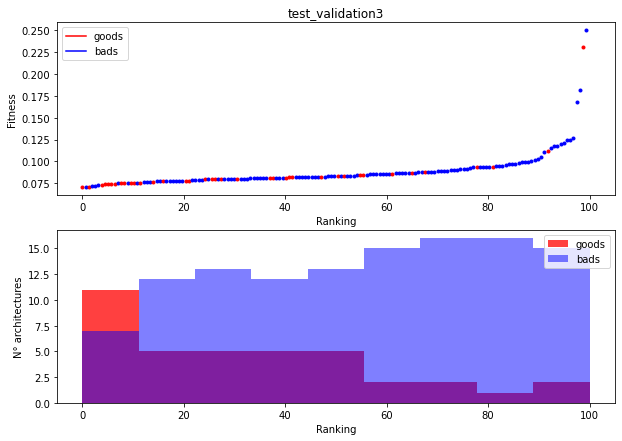

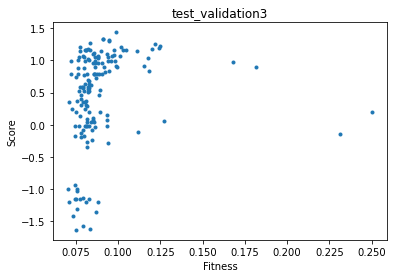




[0.070693  0.0764756 0.0822582 0.0880408 0.0938234 0.099606 ]
178 135


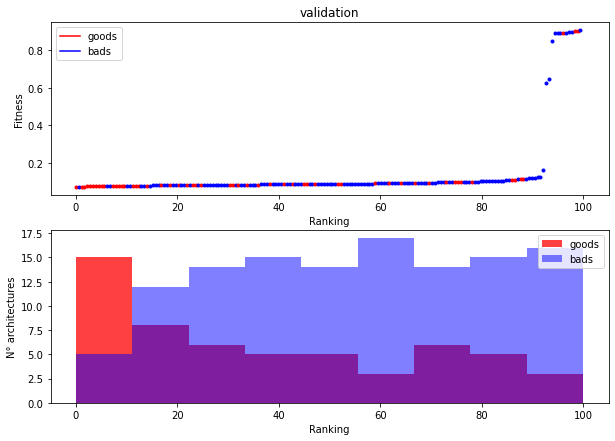

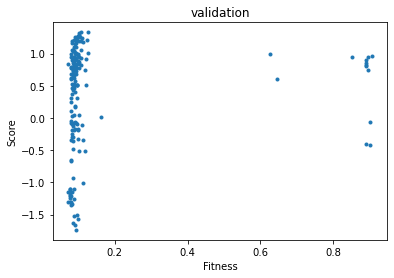




'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
[0.070685  0.0765306 0.0823762 0.0882218 0.0940674 0.099913 ]
1300 642


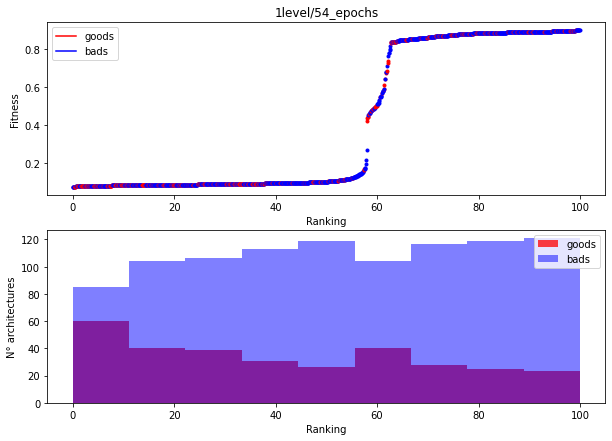

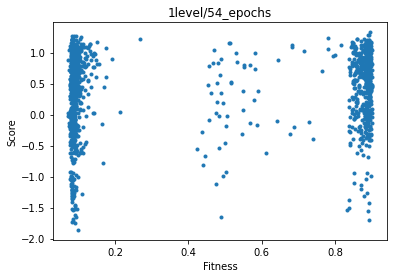




'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
[0.068361 0.074682 0.081003 0.087324 0.093645 0.099966]
1717 852


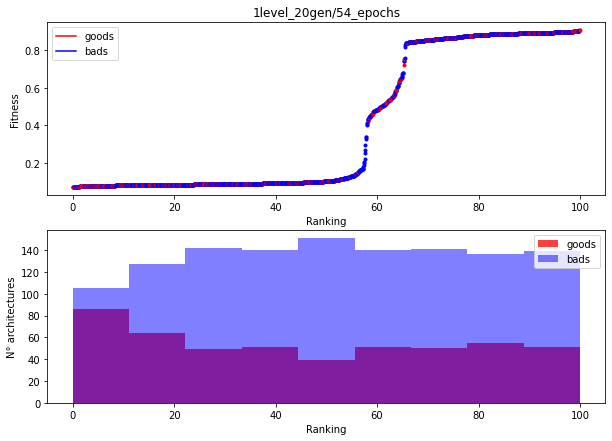

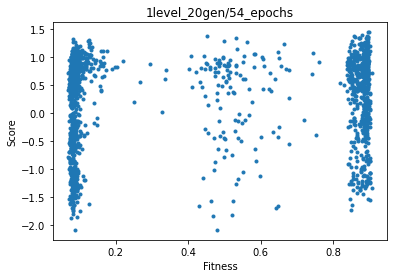




[0.066745  0.0733488 0.0799526 0.0865564 0.0931602 0.099764 ]
546 420


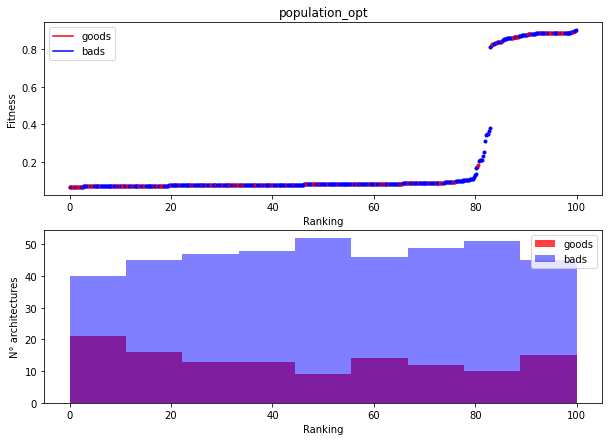

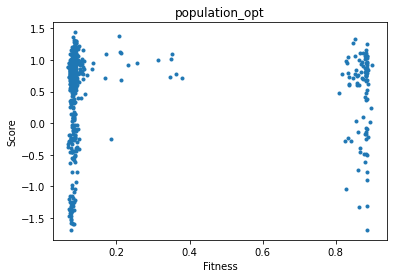




[Errno 2] No such file or directory: '../../evolved_data/random_search/54_epochs/0/MRDBI/genetic'
Trying with folder: ../../evolved_data/random_search/54_epochs/0/MRDBI/RS
Loading file ../../evolved_data/random_search/54_epochs/0/MRDBI/RS/1_2020-07-08-06:09/GA_experiment
'RandomSearcher' object has no attribute 'history_precision_fitness'
loading only first level
[Errno 2] No such file or directory: '../../evolved_data/random_search/54_epochs/3/MRDBI/genetic'
Trying with folder: ../../evolved_data/random_search/54_epochs/3/MRDBI/RS
Loading file ../../evolved_data/random_search/54_epochs/3/MRDBI/RS/1_2020-07-10-16:30/GA_experiment
'RandomSearcher' object has no attribute 'history_precision_fitness'
loading only first level
[Errno 2] No such file or directory: '../../evolved_data/random_search/54_epochs/1/MRDBI/genetic'
Trying with folder: ../../evolved_data/random_search/54_epochs/1/MRDBI/RS
Loading file ../../evolved_data/random_search/54_epochs/1/MRDBI/RS/1_2020-07-09-01:20/GA_expe

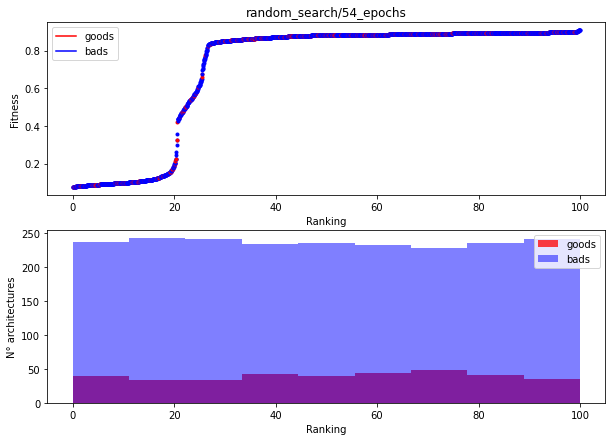

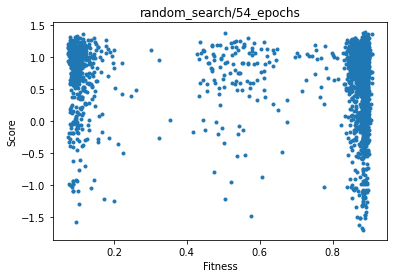

In [19]:
# Evaluate on raw datasets
dataset_names = ['test_validation3','validation', '1level/54_epochs', 
                 '1level_20gen/54_epochs', 'population_opt', 'random_search/54_epochs']

divs_class_0 = 1
datasets = {}
for dataset in dataset_names:
    print("\n\n")
    one_level = '54' in dataset
    loader_object = RandomSearcher if 'random' in dataset else TwoLevelGA
    Xr, Yc, pdict, sorted_p = get_data('MRDBI', '../../evolved_data/%s' % dataset, loader_object=loader_object,
                      runs=None, one_level=one_level, divisions=divisions, divs_class_0=divs_class_0)
    print(len(sorted_p), len(Yc))
    rdict = evaluate_model_on_dataset(model, sorted_p, dataset)
    #rdict = evaluate_model_on_percentiles(model, pdict)
    evaluate_proba(model, sorted_p, dataset, fit_lim=1)


In [ ]:
g = []
b = []
for k, v in rdict.items():
    print(k)
    g.append(v['goods'])
    b.append(v['bads'])
    for k2, v2 in v.items():
        print("\t%s: %0.2f" % (k2, v2))
        

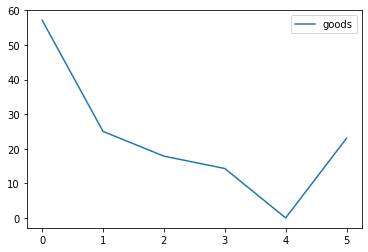

In [44]:
plt.plot(np.arange(len(g)), g, label='goods')
plt.legend()
plt.show()

In [29]:
pdict.keys()

dict_keys(['b1', 'b2', 'b3', 'b4', 'b5', 'all'])

In [47]:
np.flip(np.arange(10))

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])